<a href="https://colab.research.google.com/github/ramda1/proejct/blob/main/AI_10_%EB%82%A8%EB%8B%A4%EC%86%9C_cp2(%EA%B0%9C%EC%9D%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 셋팅

## 1) 모듈 가져오기

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import pandas as pd
import os
import glob
import os.path
import re

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


## 2) 데이터 가져오기

In [55]:
# 남성 음성 데이터

data_m = pd.read_excel('/content/drive/MyDrive/감성대화말뭉치AI데이터_평가용Wave_대본1만문장.xlsx', sheet_name = 2)
data_m

,NO.,성우,연령,성별,상황키워드,감정_대분류,감정_소분류,사람문장1
0,M_000001,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 아빠는 나한테 제대로 된 선물 한 번 준 적 없으셔.
1,M_000002,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",아무도 내 생일은 안 챙겨줘.
2,M_000003,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",내가 내 생각을 말하려고 할 때마다 아빠는 나를 때리셨어.
3,M_000004,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",이렇게 작은 집에 사는 사람은 나밖에 없을 것 같아.
4,M_000005,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 집은 왜 이렇게 가난한 건지 모르겠어.
...,...,...,...,...,...,...,...,...
4995,M_004996,YYH,중년,남성,"대인관계(부부, 자녀)",상처,희생된,가족들은 나를 돈이 필요할 때만 찾아서 내 자신이 비참하다고 느껴.
4996,M_004997,YYH,중년,남성,"대인관계(부부, 자녀)",상처,희생된,아내가 나 몰래 식당에서 일을 하고 있었더라고. 아마도 자존심 강한 내게 말하기 힘...
4997,M_004998,YYH,중년,남성,"대인관계(부부, 자녀)",상처,희생된,아내는 아직도 나를 위해 아침을 챙겨주는데 그게 힘들다고 말해서 상처를 받았어.
4998,M_004999,YYH,중년,남성,"대인관계(부부, 자녀)",상처,희생된,아내가 내가 벌어다 주는 적은 돈으로 큰살림을 꾸려나가는 걸 보면 안쓰러워.


In [56]:
# 결측치 확인(data_m)

data_m.isnull().sum()

NO.       0
성우        0
연령        0
성별        0
상황키워드     0
감정_대분류    0
감정_소분류    0
사람문장1     0
dtype: int64

In [57]:
# 여성 음성 데이터

data_f = pd.read_excel('/content/drive/MyDrive/감성대화말뭉치AI데이터_평가용Wave_대본1만문장.xlsx', sheet_name = 3)
data_f_x = data_f.drop(['Unnamed: 8'], axis = 1)
data_f_x      

,NO.,성우,연령,성별,상황키워드,감정_대분류,감정_소분류,사람문장1
0,F_000001,LSW,청소년,여성,학교폭력/따돌림,상처,"가난한, 불우한",우리 집이 잘 못산다는 것을 친구들이 알게 되었을 때 정말 억장이 무너지는 것 같았어.
1,F_000002,LSW,청소년,여성,학교폭력/따돌림,상처,"가난한, 불우한",학급비를 내지 못하고 있을 때 친구들에게 따돌림을 당할까봐 심장이 조마조마 했어.
2,F_000003,LSW,청소년,여성,학교폭력/따돌림,상처,"가난한, 불우한",부모님의 지갑을 보고 나니 체험학습 비 달라는 말을 못하겠어.
3,F_000004,LSW,청소년,여성,학교폭력/따돌림,상처,"가난한, 불우한",우리 집이 불우한 것이 친구들 사이에선 놀림거리로 여겨지고 있어.
4,F_000005,LSW,청소년,여성,학교폭력/따돌림,상처,"가난한, 불우한",내가 돈이 없는 것으로 인해 따돌림 당한다는 사실을 부모님이 알아버리셨어
...,...,...,...,...,...,...,...,...
4995,F_004996,SYS,노년,여성,재정,슬픔,환멸을 느끼는,내 동생은 몸이 아픈데도 불구하고 도박은 꾸준히 하러 나가.
4996,F_004997,SYS,노년,여성,재정,슬픔,환멸을 느끼는,소득이 너무 적어서 제대로 된 노후 대책을 할 수가 없어 힘들어.
4997,F_004998,SYS,노년,여성,"건강,죽음",상처,충격받은,요즘 두통이 잦았는데 결국 이런 일이 생겼네. 난 건강한 줄 알았는데 충격받았어.
4998,F_004999,SYS,노년,여성,재정,불안,걱정스러운,친구가 돈이 행복의 전부가 아니라고 하더니 노후 준비를 전혀 안 한 거야. 어휴 정...


In [58]:
# 결측치 확인(data_f, data_f_x)

data_f.isnull().sum()
data_f_x.isnull().sum()

NO.       0
성우        0
연령        0
성별        0
상황키워드     0
감정_대분류    0
감정_소분류    0
사람문장1     0
dtype: int64

In [59]:
# 남성, 여성 음성 데이터 합치기

data = pd.concat([data_m, data_f_x])
data

,NO.,성우,연령,성별,상황키워드,감정_대분류,감정_소분류,사람문장1
0,M_000001,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 아빠는 나한테 제대로 된 선물 한 번 준 적 없으셔.
1,M_000002,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",아무도 내 생일은 안 챙겨줘.
2,M_000003,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",내가 내 생각을 말하려고 할 때마다 아빠는 나를 때리셨어.
3,M_000004,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",이렇게 작은 집에 사는 사람은 나밖에 없을 것 같아.
4,M_000005,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 집은 왜 이렇게 가난한 건지 모르겠어.
...,...,...,...,...,...,...,...,...
4995,F_004996,SYS,노년,여성,재정,슬픔,환멸을 느끼는,내 동생은 몸이 아픈데도 불구하고 도박은 꾸준히 하러 나가.
4996,F_004997,SYS,노년,여성,재정,슬픔,환멸을 느끼는,소득이 너무 적어서 제대로 된 노후 대책을 할 수가 없어 힘들어.
4997,F_004998,SYS,노년,여성,"건강,죽음",상처,충격받은,요즘 두통이 잦았는데 결국 이런 일이 생겼네. 난 건강한 줄 알았는데 충격받았어.
4998,F_004999,SYS,노년,여성,재정,불안,걱정스러운,친구가 돈이 행복의 전부가 아니라고 하더니 노후 준비를 전혀 안 한 거야. 어휴 정...


In [60]:
# 결측치 확인(data_f)

data.isnull().sum()

NO.       0
성우        0
연령        0
성별        0
상황키워드     0
감정_대분류    0
감정_소분류    0
사람문장1     0
dtype: int64

In [61]:
# 각 감정 데이터 개수 확인

data['감정_대분류'].value_counts()

슬픔    1691
기쁨    1679
불안    1677
상처    1666
분노    1660
당황    1627
Name: 감정_대분류, dtype: int64

In [62]:
data

,NO.,성우,연령,성별,상황키워드,감정_대분류,감정_소분류,사람문장1
0,M_000001,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 아빠는 나한테 제대로 된 선물 한 번 준 적 없으셔.
1,M_000002,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",아무도 내 생일은 안 챙겨줘.
2,M_000003,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",내가 내 생각을 말하려고 할 때마다 아빠는 나를 때리셨어.
3,M_000004,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",이렇게 작은 집에 사는 사람은 나밖에 없을 것 같아.
4,M_000005,JYC,청소년,남성,가족관계,상처,"가난한, 불우한",우리 집은 왜 이렇게 가난한 건지 모르겠어.
...,...,...,...,...,...,...,...,...
4995,F_004996,SYS,노년,여성,재정,슬픔,환멸을 느끼는,내 동생은 몸이 아픈데도 불구하고 도박은 꾸준히 하러 나가.
4996,F_004997,SYS,노년,여성,재정,슬픔,환멸을 느끼는,소득이 너무 적어서 제대로 된 노후 대책을 할 수가 없어 힘들어.
4997,F_004998,SYS,노년,여성,"건강,죽음",상처,충격받은,요즘 두통이 잦았는데 결국 이런 일이 생겼네. 난 건강한 줄 알았는데 충격받았어.
4998,F_004999,SYS,노년,여성,재정,불안,걱정스러운,친구가 돈이 행복의 전부가 아니라고 하더니 노후 준비를 전혀 안 한 거야. 어휴 정...


# 2. 감정 라벨링

## 1) 파일명 변경(감정별 범위지정)

### (1) 남성

In [63]:
# 감정 대분류(남성) 값 조회

m_emotion = (data.성별 == '남성')
m_emotion_a = data[m_emotion]
m_emotion_a['감정_대분류'].value_counts()

슬픔    845
분노    844
불안    840
기쁨    827
당황    825
상처    819
Name: 감정_대분류, dtype: int64

In [64]:
# 남성 음성 데이터 지정

files_m = glob.glob('/content/drive/MyDrive/음성인식/M*.wav')
files_m = sorted(files_m)


#### a. 슬픔

In [65]:
# 감정 소분류(남성, 슬픔) 값 조회

m_sad = (data.성별 == '남성') & (data.감정_대분류 == '슬픔')
m_sad_a = data[m_sad]
m_sad_a['감정_소분류'].value_counts()

실망한        85
환멸을 느끼는    85
낙담한        84
눈물이 나는     84
마비된        84
비통한        84
슬픔         84
염세적인       84
우울한        84
후회되는       84
열등감         2
상처          1
Name: 감정_소분류, dtype: int64

In [66]:
# 남성(슬픔, 실망) 범위 지정
m_sad_dis = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '실망한')
data[m_sad_dis]
files_m_sad_dis = files_m[2599:2684]
len(files_m_sad_dis)

# 남성(슬픔, 환멸) 범위 지정
m_sad_lus = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '환멸을 느끼는')
data[m_sad_lus]
files_m_sad_lus = files_m[4609:4694]
len(files_m_sad_lus)

# 남성(슬픔, 낙담) 범위 지정
m_sad_lose = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '낙담한')
data[m_sad_lose]
files_m_sad_lose = files_m[673:757]
len(files_m_sad_lose)

# 남성(슬픔, 눈물) 범위 지정
m_sad_tears = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '눈물이 나는')
data[m_sad_tears]
files_m_sad_tears = files_m[925:1009]
len(files_m_sad_tears)

# 남성(슬픔, 마비) 범위 지정
m_sad_no = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '마비된')
data[m_sad_no]
files_m_sad_no = files_m[1344:1428]
len(files_m_sad_no)

# 남성(슬픔, 비통) 범위 지정
m_sad_grieve = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '비통한')
data[m_sad_grieve]
files_m_sad_grieve = files_m[2011:2095]
len(files_m_sad_grieve)

# 남성(슬픔, 슬픔) 범위 지정
m_sad_sad = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '슬픔')
data[m_sad_sad]
files_m_sad_sad = files_m[2347:2431]
len(files_m_sad_sad)

# 남성(슬픔, 염세) 범위 지정
m_sad_pes = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '염세적인')
data[m_sad_pes]
files_m_sad_pes = files_m[3101:3185]
len(files_m_sad_pes)

# 남성(슬픔, 우울) 범위 지정
m_sad_blue = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '우울한')
data[m_sad_blue]
files_m_sad_blue = files_m[3270:3354]
len(files_m_sad_blue)

# 남성(슬픔, 후회) 범위 지정
m_sad_regret = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '후회되는')
data[m_sad_regret]
files_m_sad_regret = files_m[4778:4862]
len(files_m_sad_regret)

# 남성(슬픔, 열등감) 범위 지정
m_sad_complex = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '열등감')
data[m_sad_complex]
files_m_sad_complex = files_m[3093:3095]
len(files_m_sad_complex)

# 남성(슬픔, 상처) 범위 지정
m_sad_hurt = (data.성별 == '남성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '상처')
data[m_sad_hurt]
files_m_sad_hurt = files_m[2174:2175]
len(files_m_sad_hurt)

1

In [67]:
# m_sad(남성, 슬픔) 범위 지정

m_sad_mix = files_m_sad_dis + files_m_sad_lus + files_m_sad_lose + files_m_sad_tears + files_m_sad_no + files_m_sad_grieve + files_m_sad_sad + files_m_sad_pes + files_m_sad_blue + files_m_sad_regret + files_m_sad_complex + files_m_sad_hurt
len(m_sad_mix)

845

#### b. 분노

In [68]:
# 감정 소분류(남성, 분노) 값 조회

m_anger = (data.성별 == '남성') & (data.감정_대분류 == '분노')
m_anger_a = data[m_anger]
m_anger_a['감정_소분류'].value_counts()

안달하는      86
좌절한       85
툴툴대는      85
노여워하는     84
방어적인      84
성가신       84
악의적인      84
짜증내는      84
분노        83
구역질 나는    43
구역질나는     42
Name: 감정_소분류, dtype: int64

In [69]:
# 남성(분노, 안달) 범위 지정
m_anger_im = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '안달하는')
data[m_anger_im]
files_m_anger_im = files_m[2768:2854]
len(files_m_anger_im)

# 남성(분노, 좌절) 범위 지정
m_anger_fru = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '좌절한')
data[m_anger_fru]
files_m_anger_fru = files_m[3522:3607]
len(files_m_anger_fru)

# 남성(분노, 툴툴) 범위 지정
m_anger_com = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '툴툴대는')
data[m_anger_com]
files_m_anger_com = files_m[4111:4196]
len(files_m_anger_com)

# 남성(분노, 노여움) 범위 지정
m_anger_off = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '노여워하는')
data[m_anger_off]
files_m_anger_off = files_m[841:925]
len(files_m_anger_off)

# 남성(분노, 방어) 범위 지정
m_anger_def = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '방어적인')
data[m_anger_def]
files_m_anger_def = files_m[1507:1591]
len(files_m_anger_def)

# 남성(분노, 성가심) 범위 지정
m_anger_ann = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '성가신')
data[m_anger_ann]
files_m_anger_ann = files_m[2179:2263]
len(files_m_anger_ann)

# 남성(분노, 악의) 범위 지정
m_anger_mal = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '악의적인')
data[m_anger_mal]
files_m_anger_mal = files_m[2684:2768]
len(files_m_anger_mal)

# 남성(분노, 짜증) 범위 지정
m_anger_irr = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '짜증내는')
data[m_anger_irr]
files_m_anger_irr = files_m[3775:3859]
len(files_m_anger_irr)

# 남성(분노, 분노) 범위 지정
m_anger_ang = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '분노')
data[m_anger_ang]
files_m_anger_ang = files_m[1843:1927]
len(files_m_anger_ang)

# 남성(분노, 구역질1) 범위 지정
m_anger_gus = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '구역질 나는')
data[m_anger_gus]
files_m_anger_gus = files_m[504:546]
len(files_m_anger_gus)

# 남성(분노, 구역질2) 범위 지정
m_anger_gust = (data.성별 == '남성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '구역질나는')
data[m_anger_gust]
files_m_anger_gust = files_m[547:589]
len(files_m_anger_gust)

42

In [70]:
# m_anger(남성, 분노) 범위 지정

m_anger_mix = files_m_anger_im + files_m_anger_fru + files_m_anger_com + files_m_anger_off + files_m_anger_def + files_m_anger_ann + files_m_anger_mal + files_m_anger_irr + files_m_anger_ang + files_m_anger_gus + files_m_anger_gust
len(m_anger_mix)

844

#### c. 불안

In [71]:
# 감정 소분류(남성, 불안) 값 조회

m_anxiety = (data.성별 == '남성') & (data.감정_대분류 == '불안')
m_anxiety_a = data[m_anxiety]
m_anxiety_a['감정_소분류'].value_counts()

걱정스러운      84
당혹스러운      84
두려운        84
불안         84
조심스러운      84
초조한        84
취약한        84
혼란스러운      84
회의적인       84
스트레스 받는    43
스트레스받는     41
Name: 감정_소분류, dtype: int64

In [72]:
# 남성(불안, 걱정) 범위 지정
m_anxiety_worry = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '걱정스러운')
data[m_anxiety_worry]
files_m_anxiety_worry = files_m[168:252]
len(files_m_anxiety_worry)

# 남성(불안, 당혹) 범위 지정
m_anxiety_emb = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '당혹스러운')
data[m_anxiety_emb]
files_m_anxiety_emb = files_m[1093:1177]
len(files_m_anxiety_emb)

# 남성(불안, 두려움) 범위 지정
m_anxiety_fear = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '두려운')
data[m_anxiety_fear]
files_m_anxiety_fear = files_m[1260:1344]
len(files_m_anxiety_fear)

# 남성(불안, 불안) 범위 지정
m_anxiety_anxiety = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '불안')
data[m_anxiety_anxiety]
files_m_anxiety_anxiety = files_m[1927:2011]
len(files_m_anxiety_anxiety)

# 남성(불안, 조심) 범위 지정
m_anxiety_careful = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '조심스러운')
data[m_anxiety_careful]
files_m_anxiety_careful = files_m[3438:3522]
len(files_m_anxiety_careful)

# 남성(불안, 초조) 범위 지정
m_anxiety_nervous = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '초조한')
data[m_anxiety_nervous]
files_m_anxiety_nervous = files_m[3859:3943]
len(files_m_anxiety_nervous)

# 남성(불안, 취약) 범위 지정
m_anxiety_weak = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '취약한')
data[m_anxiety_weak]
files_m_anxiety_weak = files_m[4027:4111]
len(files_m_anxiety_weak)

# 남성(불안, 혼란2) 범위 지정
m_anxiety_confuse = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '혼란스러운')
data[m_anxiety_confuse]
files_m_anxiety_confuse = files_m[4459:4480]
len(files_m_anxiety_confuse)

# 남성(불안, 혼란2) 범위 지정
m_anxiety_confuset = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '혼란스러운')
data[m_anxiety_confuset]
files_m_anxiety_confuset = files_m[4501:4564]
len(files_m_anxiety_confuset)

# 남성(불안, 회의적) 범위 지정
m_anxiety_skeptical = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '회의적인')
data[m_anxiety_skeptical]
files_m_anxiety_skeptical = files_m[4693:4777]
len(files_m_anxiety_skeptical)

# 남성(불안, 스트레스1) 범위 지정
m_anxiety_stress = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스 받는')
data[m_anxiety_stress]
files_m_anxiety_stress = files_m[2263:2306]
len(files_m_anxiety_stress)

# 남성(불안, 스트레스2) 범위 지정
m_anxiety_stresst = (data.성별 == '남성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스받는')
data[m_anxiety_stresst]
files_m_anxiety_stresst = files_m[2306:2347]
len(files_m_anxiety_stresst)

41

In [73]:
# m_anxiety(남성, 불안) 범위 지정

m_anxiety_mix = files_m_anxiety_worry + files_m_anxiety_emb + files_m_anxiety_fear + files_m_anxiety_anxiety + files_m_anxiety_careful + files_m_anxiety_nervous + files_m_anxiety_weak + files_m_anxiety_confuse + files_m_anxiety_confuset + files_m_anxiety_skeptical + files_m_anxiety_stress + files_m_anxiety_stresst
len(m_anxiety_mix)

840

#### d. 기쁨

In [74]:
# 감정 소분류(남성, 기쁨) 값 조회

m_joy = (data.성별 == '남성') & (data.감정_대분류 == '기쁨')
m_joy_a = data[m_joy]
m_joy_a['감정_소분류'].value_counts()

안도       85
감사하는     84
기쁨       84
느긋       84
신뢰하는     84
신이 난     84
자신하는     84
편안한      84
만족스러운    79
흥분       75
Name: 감정_소분류, dtype: int64

In [75]:
# 남성(기쁨, 안도) 범위 지정
m_joy_relief = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '안도')
data[m_joy_relief]
files_m_joy_relief = files_m[2854:2939]
len(files_m_joy_relief)

# 남성(기쁨, 감사) 범위 지정
m_joy_thanks = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '감사하는')
data[m_joy_thanks]
files_m_joy_thanks = files_m[84:168]
len(files_m_joy_thanks)

# 남성(기쁨, 기쁨) 범위 지정
m_joy_joy = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '기쁨')
data[m_joy_joy]
files_m_joy_joy = files_m[589:673]
len(files_m_joy_joy)

# 남성(기쁨, 느긋) 범위 지정
m_joy_easy = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '느긋')
data[m_joy_easy]
files_m_joy_easy = files_m[1009:1093]
len(files_m_joy_easy)

# 남성(기쁨, 신뢰하는) 범위 지정
m_joy_trust = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '신뢰하는')
data[m_joy_trust]
files_m_joy_trust = files_m[2431:2515]
len(files_m_joy_trust)

# 남성(기쁨, 신남) 범위 지정
m_joy_excited = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '신이 난')
data[m_joy_excited]
files_m_joy_excited = files_m[2515:2599]
len(files_m_joy_excited)

# 남성(기쁨, 자신감) 범위 지정
m_joy_sure = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '자신하는')
data[m_joy_sure]
files_m_joy_sure = files_m[3354:3438]
len(files_m_joy_sure)

# 남성(기쁨, 편안) 범위 지정
m_joy_comfortable = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '편안한')
data[m_joy_comfortable]
files_m_joy_comfortable = files_m[4196:4280]
len(files_m_joy_comfortable)

# 남성(기쁨, 만족) 범위 지정
m_joy_satisfied = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '만족스러운')
data[m_joy_satisfied]
files_m_joy_satisfied = files_m[1428:1507]
len(files_m_joy_satisfied)

# 남성(기쁨, 흥분) 범위 지정
m_joy_up = (data.성별 == '남성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '흥분')
data[m_joy_up]
files_m_joy_up = files_m[4862:4937]
len(files_m_joy_up)

75

In [76]:
# m_joy(남성, 기쁨) 범위 지정

m_joy_mix = files_m_joy_relief + files_m_joy_thanks + files_m_joy_joy + files_m_joy_easy + files_m_joy_trust + files_m_joy_excited + files_m_joy_sure + files_m_joy_comfortable + files_m_joy_satisfied + files_m_joy_up
len(m_joy_mix)

827

### (2) 여성

In [77]:
# 감정 대분류(여성) 값 조회

f_emotion = (data.성별 == '여성')
f_emotion_a = data[f_emotion]
f_emotion_a['감정_대분류'].value_counts()

기쁨    852
상처    847
슬픔    846
불안    837
분노    816
당황    802
Name: 감정_대분류, dtype: int64

In [78]:
# 여성 음성 데이터 지정

files_f = glob.glob('/content/drive/MyDrive/음성인식/F*.wav')
files_f = sorted(files_f)

#### a. 슬픔

In [79]:
# 감정 소분류(여성, 슬픔) 값 조회

f_sad = (data.성별 == '여성') & (data.감정_대분류 == '슬픔')
f_sad_a = data[f_sad]
f_sad_a['감정_소분류'].value_counts()

환멸을 느끼는    87
우울한        85
낙담한        84
눈물이 나는     84
마비된        84
비통한        84
슬픔         84
실망한        84
염세적인       84
후회되는       84
성가신         1
외로운         1
Name: 감정_소분류, dtype: int64

In [80]:
# 여성(슬픔, 환멸1) 범위 지정
f_sad_lus = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '환멸을 느끼는')
data[f_sad_lus]
files_f_sad_lus = files_f[4535:4620]
len(files_f_sad_lus)

# 여성(슬픔, 환멸2) 범위 지정
f_sad_lust = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '환멸을 느끼는')
data[f_sad_lust]
files_f_sad_lust = files_f[4995:4997]
len(files_f_sad_lust)

# 여성(슬픔, 우울) 범위 지정
f_sad_blue = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '우울한')
data[f_sad_blue]
files_f_sad_blue = files_f[3206:3291]
len(files_f_sad_blue)

# 여성(슬픔, 낙담) 범위 지정
f_sad_lose = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '낙담한')
data[f_sad_lose]
files_f_sad_lose = files_f[660:744]
len(files_f_sad_lose)

# 여성(슬픔, 눈물) 범위 지정
f_sad_tears = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '눈물이 나는')
data[f_sad_tears]
files_f_sad_tears = files_f[904:988]
len(files_f_sad_tears)

# 여성(슬픔, 마비) 범위 지정
f_sad_no = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '마비된')
data[f_sad_no]
files_f_sad_no = files_f[1315:1399]
len(files_f_sad_no)

# 여성(슬픔, 비통) 범위 지정
f_sad_grieve = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '비통한')
data[f_sad_grieve]
files_f_sad_grieve = files_f[1967:2051]
len(files_f_sad_grieve)

# 여성(슬픔, 슬픔) 범위 지정
f_sad_sad = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '슬픔')
data[f_sad_sad]
files_f_sad_sad = files_f[2299:2383]
len(files_f_sad_sad)

# 여성(슬픔, 실망) 범위 지정
f_sad_dis = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '실망한')
data[f_sad_dis]
files_f_sad_dis = files_f[2549:2633]
len(files_f_sad_dis)

# 여성(슬픔, 염세) 범위 지정
f_sad_pes = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '염세적인')
data[f_sad_pes]
files_f_sad_pes = files_f[3045:3129]
len(files_f_sad_pes)

# 여성(슬픔, 후회) 범위 지정
f_sad_regret = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '후회되는')
data[f_sad_regret]
files_f_sad_regret = files_f[4705:4789]
len(files_f_sad_regret)

# 여성(슬픔, 성가심) 범위 지정
f_sad_anno = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '성가신')
data[f_sad_anno]
files_f_sad_anno = files_f[2197:2198]
len(files_f_sad_anno)

# 여성(슬픔, 외로움) 범위 지정
f_sad_lonely = (data.성별 == '여성') & (data.감정_대분류 == '슬픔') & (data.감정_소분류 == '외로운')
data[f_sad_lonely]
files_f_sad_lonely = files_f[3191:3192]
len(files_f_sad_lonely)

1

In [81]:
# f_sad(여성, 슬픔) 범위 지정

f_sad_mix = files_f_sad_dis + files_f_sad_lus + files_f_sad_lust + files_f_sad_lose + files_f_sad_tears + files_f_sad_no + files_f_sad_grieve + files_f_sad_sad + files_f_sad_pes + files_f_sad_blue + files_f_sad_regret + files_f_sad_anno + files_f_sad_lonely
len(f_sad_mix)

846

#### b. 분노

In [82]:
# 감정 소분류(여성, 분노) 값 조회

f_anger = (data.성별 == '여성') & (data.감정_대분류 == '분노')
f_anger_a = data[f_anger]
f_anger_a['감정_소분류'].value_counts()

안달하는       86
좌절한        85
분노         84
짜증내는       84
툴툴대는       84
성가신        83
악의적인       80
노여워하는      77
방어적인       72
구역질나는      43
구역질 나는     36
스트레스 받는     1
희생된         1
Name: 감정_소분류, dtype: int64

In [83]:
# 여성(분노, 안달1) 범위 지정
f_anger_im = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '안달하는')
data[f_anger_im]
files_f_anger_im = files_f[2713:2798]
len(files_f_anger_im)

# 여성(분노, 안달2) 범위 지정
f_anger_imt = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '안달하는')
data[f_anger_imt]
files_f_anger_imt = files_f[4990:4991]
len(files_f_anger_imt)

# 여성(분노, 좌절) 범위 지정
f_anger_fru = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '좌절한')
data[f_anger_fru]
files_f_anger_fru = files_f[3460:3545]
len(files_f_anger_fru)

# 여성(분노, 분노) 범위 지정
f_anger_ang = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '분노')
data[f_anger_ang]
files_f_anger_ang = files_f[1799:1883]
len(files_f_anger_ang)

# 여성(분노, 짜증) 범위 지정
f_anger_irr = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '짜증내는')
data[f_anger_irr]
files_f_anger_irr = files_f[3714:3798]
len(files_f_anger_irr)

# 여성(분노, 툴툴) 범위 지정
f_anger_com = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '툴툴대는')
data[f_anger_com]
files_f_anger_com = files_f[4050:4134]
len(files_f_anger_com)

# 여성(분노, 성가심) 범위 지정
f_anger_ann = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '성가신')
data[f_anger_ann]
files_f_anger_ann = files_f[2135:2197]
len(files_f_anger_ann)

# 여성(분노, 성가심2) 범위 지정
f_anger_ann = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '성가신')
data[f_anger_ann]
files_f_anger_annt = files_f[2198:2219]
len(files_f_anger_annt)

# 여성(분노, 악의) 범위 지정
f_anger_mal = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '악의적인')
data[f_anger_mal]
files_f_anger_mal = files_m[2633:2713]
len(files_f_anger_mal)

# 여성(분노, 노여움) 범위 지정
f_anger_off = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '노여워하는')
data[f_anger_off]
files_f_anger_off = files_f[827:904]
len(files_f_anger_off)

# 여성(분노, 방어) 범위 지정
f_anger_def = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '방어적인')
data[f_anger_def]
files_f_anger_def = files_f[1483:1555]
len(files_f_anger_def)

# 여성(분노, 구역질1) 범위 지정
f_anger_gus = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '구역질 나는')
data[f_anger_gus]
files_f_anger_gus = files_f[497:533]
len(files_f_anger_gus)

# 여성(분노, 구역질2) 범위 지정
f_anger_gust = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '구역질나는')
data[f_anger_gust]
files_f_anger_gust = files_f[533:575]
len(files_f_anger_gust)

# 여성(분노, 구역질3) 범위 지정
f_anger_gusth = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '구역질나는')
data[f_anger_gusth]
files_f_anger_gusth = files_f[4991:4992]
len(files_f_anger_gusth)

# 여성(분노, 스트레스) 범위 지정
f_anger_stress = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '스트레스 받는')
data[f_anger_stress]
files_f_anger_stress = files_f[2253:2254]
len(files_f_anger_stress)

# 여성(분노, 희생) 범위 지정
f_anger_sacrifice = (data.성별 == '여성') & (data.감정_대분류 == '분노') & (data.감정_소분류 == '희생된')
data[f_anger_sacrifice]
files_f_anger_sacrifice = files_f[4915:4916]
len(files_f_anger_sacrifice)

1

In [84]:
# f_anger(여성, 분노) 범위 지정

f_anger_mix = files_f_anger_im + files_f_anger_imt + files_f_anger_fru + files_f_anger_com + files_f_anger_off + files_f_anger_def + files_f_anger_ann + files_f_anger_annt + files_f_anger_mal + files_f_anger_irr + files_f_anger_ang + files_f_anger_gus + files_f_anger_gust + files_f_anger_gusth + files_f_anger_stress + files_f_anger_sacrifice
len(f_anger_mix)

816

#### c. 불안

In [85]:
# 감정 소분류(여성, 불안) 값 조회

f_anxiety = (data.성별 == '여성') & (data.감정_대분류 == '불안')
f_anxiety_a = data[f_anxiety]
f_anxiety_a['감정_소분류'].value_counts()

걱정스러운      85
두려운        85
회의적인       85
불안         84
조심스러운      84
초조한        84
취약한        84
혼란스러운      84
당혹스러운      82
스트레스받는     45
스트레스 받는    35
Name: 감정_소분류, dtype: int64

In [86]:
# 여성(불안, 두려움) 범위 지정
f_anxiety_fear = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '두려운')
data[f_anxiety_fear]
files_f_anxiety_fear = files_f[1230:1315]
len(files_f_anxiety_fear)


# 여성(불안, 걱정1) 범위 지정
f_anxiety_worry = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '걱정스러운')
data[f_anxiety_worry]
files_f_anxiety_worry = files_f[170:254]
len(files_f_anxiety_worry)

# 여성(불안, 걱정2) 범위 지정
f_anxiety_worryt = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '걱정스러운')
data[f_anxiety_worryt]
files_f_anxiety_worryt = files_f[252:253]
len(files_f_anxiety_worryt)

# 여성(불안, 당혹) 범위 지정
f_anxiety_emb = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '당혹스러운')
data[f_anxiety_emb]
files_f_anxiety_emb = files_f[1072:1154]
len(files_f_anxiety_emb)

# 여성(불안, 불안) 범위 지정
f_anxiety_anxiety = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '불안')
data[f_anxiety_anxiety]
files_f_anxiety_anxiety = files_f[1883:1967]
len(files_f_anxiety_anxiety)

# 여성(불안, 조심) 범위 지정
f_anxiety_careful = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '조심스러운')
data[f_anxiety_careful]
files_f_anxiety_careful = files_f[3376:3460]
len(files_f_anxiety_careful)

# 여성(불안, 초조) 범위 지정
f_anxiety_nervous = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '초조한')
data[f_anxiety_nervous]
files_f_anxiety_nervous = files_f[3798:3882]
len(files_f_anxiety_nervous)

# 여성(불안, 취약) 범위 지정
f_anxiety_weak = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '취약한')
data[f_anxiety_weak]
files_f_anxiety_weak = files_f[3966:4050]
len(files_f_anxiety_weak)

# 여성(불안, 혼란1) 범위 지정
f_anxiety_confuse = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '혼란스러운')
data[f_anxiety_confuse]
files_f_anxiety_confuse = files_f[4388:4409]
len(files_f_anxiety_confuse)

# 여성(불안, 혼란2) 범위 지정
f_anxiety_confuset = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '혼란스러운')
data[f_anxiety_confuset]
files_f_anxiety_confuset = files_f[4430:4493]
len(files_f_anxiety_confuset)

# 여성(불안, 회의적) 범위 지정
f_anxiety_skeptical = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '회의적인')
data[f_anxiety_skeptical]
files_f_anxiety_skeptical = files_f[4620:4705]
len(files_f_anxiety_skeptical)

# 여성(불안, 스트레스1) 범위 지정
f_anxiety_stress = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스 받는')
data[f_anxiety_stress]
files_f_anxiety_stress = files_f[2219:2253]
len(files_f_anxiety_stress)

# 여성(불안, 스트레스1.5) 범위 지정
f_anxiety_stressf = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스 받는')
data[f_anxiety_stressf]
files_f_anxiety_stressf = files_f[2254:2255]
len(files_f_anxiety_stressf)

# 여성(불안, 스트레스2) 범위 지정
f_anxiety_stresst = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스받는')
data[f_anxiety_stresst]
files_f_anxiety_stresst = files_f[2255:2299]
len(files_f_anxiety_stresst)

# 여성(불안, 스트레스3) 범위 지정
f_anxiety_stressth = (data.성별 == '여성') & (data.감정_대분류 == '불안') & (data.감정_소분류 == '스트레스받는')
data[f_anxiety_stressth]
files_f_anxiety_stressth = files_f[4994:4995]
len(files_f_anxiety_stressth)

1

In [87]:
# f_anxiety(여성, 불안) 범위 지정

f_anxiety_mix = files_f_anxiety_fear + files_f_anxiety_worry + files_f_anxiety_worryt + files_f_anxiety_emb + files_f_anxiety_anxiety + files_f_anxiety_careful + files_f_anxiety_nervous + files_f_anxiety_weak + files_f_anxiety_confuse + files_f_anxiety_confuset + files_f_anxiety_skeptical + files_f_anxiety_stress + files_f_anxiety_stresst + files_f_anxiety_stressth + files_f_anxiety_stressf
len(f_anxiety_mix)

837

#### d. 기쁨

In [88]:
# 감정 소분류(여성, 기쁨) 값 조회

f_joy = (data.성별 == '여성') & (data.감정_대분류 == '기쁨')
f_joy_a = data[f_joy]
f_joy_a['감정_소분류'].value_counts()

흥분       93
감사하는     86
기쁨       85
자신하는     85
편안한      85
느긋       84
만족스러운    84
신이 난     84
안도       84
신뢰하는     82
Name: 감정_소분류, dtype: int64

In [89]:
# 여성(기쁨, 안도) 범위 지정
f_joy_relief = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '안도')
data[f_joy_relief]
files_f_joy_relief = files_f[2798:2882]
len(files_f_joy_relief)

# 여성(기쁨, 감사) 범위 지정
f_joy_thanks = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '감사하는')
data[f_joy_thanks]
files_f_joy_thanks = files_f[84:170]
len(files_f_joy_thanks)

# 여성(기쁨, 기쁨) 범위 지정
f_joy_joy = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '기쁨')
data[f_joy_joy]
files_f_joy_joy = files_f[575:660]
len(files_f_joy_joy)

# 여성(기쁨, 느긋) 범위 지정
f_joy_easy = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '느긋')
data[f_joy_easy]
files_f_joy_easy = files_f[988:1072]
len(files_f_joy_easy)

# 여성(기쁨, 신뢰하는) 범위 지정
f_joy_trust = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '신뢰하는')
data[f_joy_trust]
files_f_joy_trust = files_f[2383:2465]
len(files_f_joy_trust)

# 여성(기쁨, 신남) 범위 지정
f_joy_excited = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '신이 난')
data[f_joy_excited]
files_f_joy_excited = files_f[2465:2549]
len(files_f_joy_excited)

# 여성(기쁨, 자신감) 범위 지정
f_joy_sure = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '자신하는')
data[f_joy_sure]
files_f_joy_sure = files_f[3291:3376]
len(files_f_joy_sure)

# 여성(기쁨, 편안) 범위 지정
f_joy_comfortable = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '편안한')
data[f_joy_comfortable]
files_f_joy_comfortable = files_f[4134:4219]
len(files_f_joy_comfortable)

# 여성(기쁨, 만족) 범위 지정
f_joy_satisfied = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '만족스러운')
data[f_joy_satisfied]
files_f_joy_satisfied = files_f[1399:1483]
len(files_f_joy_satisfied)

# 여성(기쁨, 흥분1) 범위 지정
f_joy_up = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '흥분')
data[f_joy_up]
files_f_joy_up = files_f[4789:4873]
len(files_f_joy_up)

# 여성(기쁨, 흥분2) 범위 지정
f_joy_upt = (data.성별 == '여성') & (data.감정_대분류 == '기쁨') & (data.감정_소분류 == '흥분')
data[f_joy_upt]
files_f_joy_upt = files_f[4957:4966]
len(files_f_joy_upt)

9

In [90]:
# f_joy(여성, 기쁨) 범위 지정

f_joy_mix = files_f_joy_relief + files_f_joy_thanks + files_f_joy_joy + files_f_joy_easy + files_f_joy_trust + files_f_joy_excited + files_f_joy_sure + files_f_joy_comfortable + files_f_joy_satisfied + files_f_joy_up + files_f_joy_upt
len(f_joy_mix)

852

### (3) 그 외(당황, 상처) / 제거할 감정

In [91]:
# 감정 대분류(당황)

panics = (data.감정_대분류 == '당황')
emotion_pa = data[panics]


# 감정 대분류(당황)

hurts = (data.감정_대분류 == '상처')
emotion_hu = data[hurts]


#### a. 남성

In [92]:
# 그 외(당황1) 범위 지정

files_po = files_m[252:273]
len(files_po)

# 그 외(당황1.25) 범위 지정

files_potf = files_m[294:315]
len(files_potf)


# 그 외(당황1.5) 범위 지정

files_pof = files_m[378:420]
len(files_pof)


# 그 외(당황2) 범위 지정

files_pt = files_m[476:477]
len(files_pt)


# 그 외(당황3) 범위 지정

files_pth = files_m[757:841]
len(files_pth)


# 그 외(당황4) 범위 지정

files_pf = files_m[1177:1260]
len(files_pf)


# 그 외(당황5) 범위 지정

files_pfi = files_m[1759:1843]
len(files_pfi)


# 그 외(당황5.5) 범위 지정

files_pfif = files_m[1885:1886]
len(files_pfif)


# 그 외(당황6) 범위 지정

files_ps = files_m[3023:3093]
len(files_ps)


# 그 외(당황6.5) 범위 지정

files_psf = files_m[3095:3101]
len(files_psf)


# 그 외(당황6.75) 범위 지정

files_pssf = files_m[3185:3253]
len(files_pssf)

# 그 외(당황6.759) 범위 지정

files_pssfn = files_m[3254:3267]
len(files_pssfn)


# 그 외(당황6.85) 범위 지정

files_psef = files_m[3268:3270]
len(files_psef)




# 그 외(당황7) 범위 지정

files_pse = files_m[3607:3691]
len(files_pse)


# 그 외(당황8) 범위 지정

files_pe = files_m[4280:4459]
len(files_pe)


# 그 외(당황9) 범위 지정

files_pn = files_m[4480:4501]
len(files_pn)


# 그 외(당황10) 범위 지정

files_pte = files_m[4564:4609]
len(files_pte)


45

In [93]:
# 그 외(상처1) 범위 지정

files_ho = files_m[0:84]
len(files_ho)


# 그 외(상처2) 범위 지정

files_ht = files_m[273:294]
len(files_ht)


# 그 외(상처2.5) 범위 지정

files_htf = files_m[315:378]
len(files_htf)


# 그 외(상처2.75) 범위 지정

files_htsf = files_m[420:476]
len(files_htsf)

# 그 외(상처2.95) 범위 지정

files_htnf = files_m[477:504]
len(files_htnf)


# 그 외(상처3) 범위 지정

files_hth = files_m[1591:1759]
len(files_hth)


# 그 외(상처4) 범위 지정

files_hf = files_m[2095:2174]
len(files_hf)

# 그 외(상처4.5) 범위 지정

files_hff = files_m[2175:2179]
len(files_hff)


# 그 외(상처5) 범위 지정

files_hfi = files_m[2939:3023]
len(files_hfi)


# 그 외(상처6) 범위 지정

files_hs = files_m[3253:3254]
len(files_hs)


# 그 외(상처7) 범위 지정

files_hse = files_m[3267:3268]
len(files_hse)


# 그 외(상처8) 범위 지정

files_he = files_m[3691:3775]
len(files_he)


# 그 외(상처8.5) 범위 지정

files_hef = files_m[3943:4027]
len(files_hef)


# 그 외(상처9) 범위 지정

files_hn = files_m[4937:5000]
len(files_hn)

63

In [94]:
m_panic = files_po + files_potf + files_pof + files_pt + files_pth + files_pf + files_pfi + files_pfif + files_ps + files_psf + files_pssf + files_pse + files_pe + files_pn + files_pte + files_psef + files_pssfn
m_hurt = files_ho + files_ht + files_hth + files_hf + files_hfi + files_hs + files_hse + files_he + files_hn + files_htf + files_htsf + files_hef + files_htnf + files_hff
m_ph = m_panic + m_hurt
len(m_ph)

1644

#### b. 여성

In [95]:
# 그 외(당황1) 범위 지정

files_po_f = files_f[254:275]
len(files_po_f)


# 그 외(당황2) 범위 지정

files_pt_f = files_f[296:317]
len(files_pt_f)


# 그 외(당황3) 범위 지정

files_pth_f = files_f[376:413]
len(files_pth_f)


# 그 외(당황4) 범위 지정

files_pf_f = files_f[744:827]
len(files_pf_f)


# 그 외(당황5) 범위 지정

files_pfi_f = files_f[1154:1230]
len(files_pfi_f)


# 그 외(당황6) 범위 지정

files_ps_f = files_f[1715:1799]
len(files_ps_f)


# 그 외(당황7) 범위 지정

files_pse_f = files_f[2961:3045]
len(files_pse_f)


# 그 외(당황8) 범위 지정

files_pe_f = files_f[3129:3191]
len(files_pe_f)


# 그 외(당황8.5) 범위 지정

files_pef_f = files_f[3192:3206]
len(files_pef_f)


# 그 외(당황9) 범위 지정

files_pn_f = files_f[3545:3629]
len(files_pn_f)


# 그 외(당황10) 범위 지정

files_pte_f = files_f[4219:4388]
len(files_pte_f)


# 그 외(당황11) 범위 지정

files_pel_f = files_f[4409:4430]
len(files_pel_f)


# 그 외(당황12) 범위 지정

files_ptwe_f = files_f[4493:4535]
len(files_ptwe_f)


# 그 외(당황12) 범위 지정

files_pthr_f = files_f[4988:4990]
len(files_pthr_f)


# 그 외(당황13) 범위 지정

files_pfor_f = files_f[4992:4993]
len(files_pfor_f)


# 그 외(당황14) 범위 지정

files_pfora_f = files_f[4999:5000]
len(files_pfora_f)

1

In [96]:
len(files_pthr_f)

2

In [97]:
# 그 외(상처1) 범위 지정

files_ho_f = files_f[0:84]
len(files_ho_f)


# 그 외(상처2) 범위 지정

files_ht_f = files_f[275:296]
len(files_ht_f)


# 그 외(상처2.5) 범위 지정

files_htf_f = files_f[317:376]
len(files_htf_f)


# 그 외(상처2.75) 범위 지정

files_htsf_f = files_f[413:497]
len(files_htsf_f)


# 그 외(상처3) 범위 지정

files_hth_f = files_f[1555:1715]
len(files_hth_f)


# 그 외(상처4) 범위 지정

files_hf_f = files_f[2051:2135]
len(files_hf_f)


# 그 외(상처5) 범위 지정

files_hfi_f = files_f[2883:2961]
len(files_hfi_f)


# 그 외(상처6) 범위 지정

files_hs_f = files_f[3629:3714]
len(files_hs_f)


# 그 외(상처7) 범위 지정

files_hse_f = files_f[3882:3966]
len(files_hse_f)

# 그 외(상처8.5) 범위 지정

files_hef_f = files_f[4873:4957]
len(files_hef_f)


# 그 외(상처9) 범위 지정

files_hn_f = files_f[4966:4988]
len(files_hn_f)


# 그 외(상처10) 범위 지정

files_hte_f = files_f[4993:4994]
len(files_hte_f)


# 그 외(상처11) 범위 지정

files_hel_f = files_f[4997:4998]
len(files_hel_f)

1

In [98]:
f_panic = files_po_f + files_pt_f + files_pth_f + files_pf_f + files_pfi_f + files_ps_f + files_pse_f + files_pe_f + files_pn_f + files_pte_f + files_pel_f + files_ptwe_f + files_pthr_f + files_pfor_f + files_pef_f + files_pfora_f
f_hurt = files_ho_f + files_ht_f + files_htf_f + files_htsf_f + files_hth_f + files_hf_f + files_hfi_f + files_hs_f + files_hse_f + files_hef_f + files_hn_f + files_hte_f + files_hel_f
f_ph = f_panic + f_hurt
len(f_ph)

1649

## 2) 경로 지정

### (1) 남성

In [99]:
# # 파일명에 감정 추가(남성, 슬픔)

# ms = m_sad_mix

# for fms in ms:
#     ftitle_ms, fext_ms = os.path.splitext(fms)
#     os.rename(fms, ftitle_ms + '_sad(M)' + fext_ms)

In [100]:
# # 파일명에 감정 추가(남성, 분노)

# ma = m_anger_mix

# for fma in ma:
#     ftitle_ma, fext_ma = os.path.splitext(fma)
#     os.rename(fma, ftitle_ma + '_ang(M)' + fext_ma)

In [101]:
# # 파일명에 감정 추가(남성, 불안)

# maiety = m_anxiety_mix

# for fmaiety in maiety:
#     ftitle_maiety, fext_maiety = os.path.splitext(fmaiety)
#     os.rename(fmaiety, ftitle_maiety + '_aiety(M)' + fext_maiety)

In [102]:
# # 파일명에 감정 추가(남성, 기쁨)

# mjo = m_joy_mix

# for fmjo in mjo:
#     ftitle_mjo, fext_mjo = os.path.splitext(fmjo)
#     os.rename(fmjo, ftitle_mjo + '_joy(M)' + fext_mjo)

In [103]:
# 파일 확인

m_joy_mix[1]

am = glob.glob('/content/drive/MyDrive/음성인식/*003720*.wav')
am

['/content/drive/MyDrive/음성인식/M_003720_hurt(M).wav',
 '/content/drive/MyDrive/음성인식/F_003720.wav']

### (2) 여성

In [104]:
# # 파일명에 감정 추가(여성, 슬픔)

# fs = f_sad_mix

# for ffs in fs:
#     ftitle_fs, fext_fs = os.path.splitext(ffs)
#     os.rename(ffs, ftitle_fs + '_sad(F)' + fext_fs)

In [105]:
# # 파일명에 감정 추가(여성, 분노)

# fa = f_anger_mix

# for ffa in fa:
#     ftitle_fa, fext_fa = os.path.splitext(ffa)
#     os.rename(ffa, ftitle_fa + '_ang(F)' + fext_fa)

In [106]:
# # 파일명에 감정 추가(여성, 불안)

# faiety = f_anxiety_mix

# for ffaiety in faiety:
#     ftitle_faiety, fext_faiety = os.path.splitext(ffaiety)
#     os.rename(ffaiety, ftitle_faiety + '_aiety(F)' + fext_faiety)

In [107]:
# # 파일명에 감정 추가(여성, 기쁨)

# fjo = f_joy_mix

# for ffjo in fjo:
#     ftitle_fjo, fext_fjo = os.path.splitext(ffjo)
#     os.rename(ffjo, ftitle_fjo + '_joy(F)' + fext_fjo)

In [108]:
# 파일 확인

f_joy_mix[1]

cm = glob.glob('/content/drive/MyDrive/음성인식/F_00280*.wav')
cm

len(f_joy_mix)

852

### (3) 그 외(당황, 상처) / 제거할 감정

In [109]:
# # 파일명에 감정 추가(남성, 당황)

# mp = m_panic

# for mpc in mp:
#     ftitle_mp, fext_mp = os.path.splitext(mpc)
#     os.rename(mpc, ftitle_mp + '_panic(M)' + fext_mp)

In [110]:
# # 파일명에 감정 추가(남성, 상처)

# mh = m_hurt

# for mht in mh:
#     ftitle_mh, fext_mh = os.path.splitext(mht)
#     os.rename(mht, ftitle_mh + '_hurt(M)' + fext_mh)

In [111]:
# # 파일명에 감정 추가(여성, 당황)

# fp = f_panic

# for fpc in fp:
#     ftitle_fp, fext_fp = os.path.splitext(fpc)
#     os.rename(fpc, ftitle_fp + '_panic(F)' + fext_fp)

In [112]:
# # 파일명에 감정 추가(여성, 상처)

# fh = f_hurt

# for fht in fh:
#     ftitle_fh, fext_fh = os.path.splitext(fht)
#     os.rename(fht, ftitle_fh + '_hurt(F)' + fext_fh)

In [113]:
# 파일 확인

f_hurt[0]

cm = glob.glob('/content/drive/MyDrive/음성인식/F_00000*.wav')
cm

['/content/drive/MyDrive/음성인식/F_000001_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000002_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000003_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000004_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000005_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000006_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000007_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000008_hurt(F).wav',
 '/content/drive/MyDrive/음성인식/F_000009_hurt(F).wav']

## 3) 감정 라벨링

In [114]:
# 파일명 분리

paths = []
labels = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/음성인식'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

In [115]:
# 확인

len(paths)
paths[100:110]
labels[100:110]

['panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)',
 'panic(f)']

In [150]:
# 데이터프레임 생성

df = pd.DataFrame()
df['location'] = paths
df['label'] = labels

df.head()

,location,label
0,/content/drive/MyDrive/음성인식/F_004317_p...,panic(f)
1,/content/drive/MyDrive/음성인식/F_004318_p...,panic(f)
2,/content/drive/MyDrive/음성인식/F_004319_p...,panic(f)
3,/content/drive/MyDrive/음성인식/F_004320_p...,panic(f)
4,/content/drive/MyDrive/음성인식/F_004321_p...,panic(f)


### (1) 남성

In [117]:
# 기쁨, 상처, 슬픔, 불안(남성)

dfm = df[(df['label'] == 'joy(m)') | (df['label'] == 'hurt(m)') | (df['label'] == 'sad(m)') | (df['label'] == 'aiety(m)')]
dfm

,location,label
1000,/content/drive/MyDrive/음성인식/M_003722_h...,hurt(m)
1001,/content/drive/MyDrive/음성인식/M_003723_h...,hurt(m)
1002,/content/drive/MyDrive/음성인식/M_003724_h...,hurt(m)
1003,/content/drive/MyDrive/음성인식/M_003725_h...,hurt(m)
1004,/content/drive/MyDrive/음성인식/M_003726_h...,hurt(m)
...,...,...
8995,/content/drive/MyDrive/음성인식/M_001348_s...,sad(m)
8996,/content/drive/MyDrive/음성인식/M_001349_s...,sad(m)
8997,/content/drive/MyDrive/음성인식/M_001350_s...,sad(m)
8998,/content/drive/MyDrive/음성인식/M_001351_s...,sad(m)


In [118]:
# 감정값 확인(남성)

dfm['label'].value_counts()

sad(m)      845
joy(m)      827
hurt(m)     819
aiety(m)    672
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


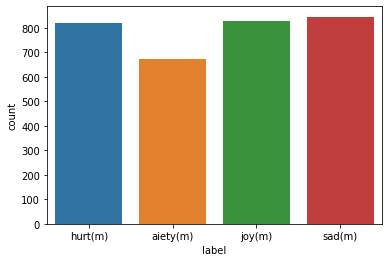

In [119]:
# 시각화(남성)

sns.countplot(dfm['label'])

### (2) 여성

In [120]:
# 기쁨, 상처, 슬픔, 불안(여성)

dff = df[(df['label'] == 'joy(f)') | (df['label'] == 'hurt(f)') | (df['label'] == 'sad(f)') | (df['label'] == 'aiety(f)')]
dff

,location,label
153,/content/drive/MyDrive/음성인식/F_000001_h...,hurt(f)
154,/content/drive/MyDrive/음성인식/F_000002_h...,hurt(f)
155,/content/drive/MyDrive/음성인식/F_000003_h...,hurt(f)
156,/content/drive/MyDrive/음성인식/F_000004_h...,hurt(f)
157,/content/drive/MyDrive/음성인식/F_000005_h...,hurt(f)
...,...,...
5995,/content/drive/MyDrive/음성인식/F_004605_s...,sad(f)
5996,/content/drive/MyDrive/음성인식/F_004606_s...,sad(f)
5997,/content/drive/MyDrive/음성인식/F_004607_s...,sad(f)
5998,/content/drive/MyDrive/음성인식/F_004608_s...,sad(f)


In [121]:
# 감정값 확인(여성)

dff['label'].value_counts()

joy(f)      852
hurt(f)     847
sad(f)      846
aiety(f)    169
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


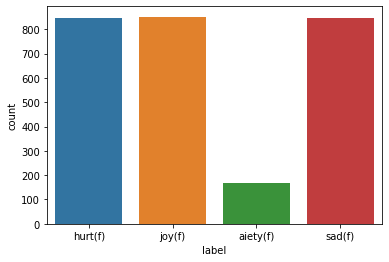

In [122]:
# 시각화(여성)

sns.countplot(dff['label'])

# 3. 음성 데이터 특징 추출

In [123]:
# 오디오 데이터, 그래프로 표현

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()


# 스펙트럼 그래프로 표현

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

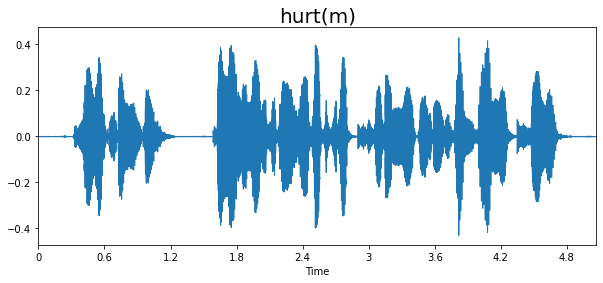

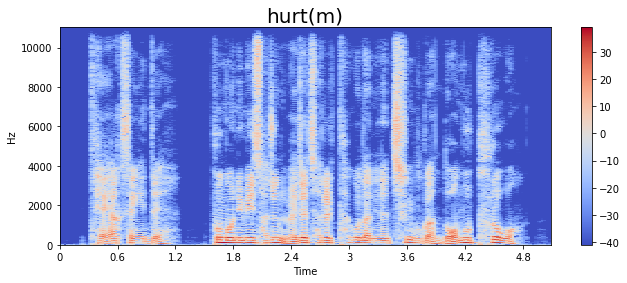

In [124]:
# 그래프(남성, 상처)

emotion = 'hurt(m)'
path = np.array(df['location'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

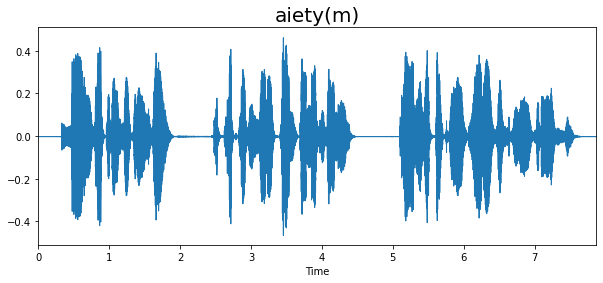

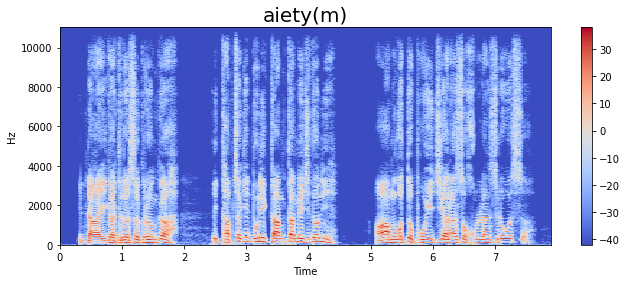

In [125]:
# 그래프(남성, 불안)

emotion = 'aiety(m)'
path = np.array(df['location'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

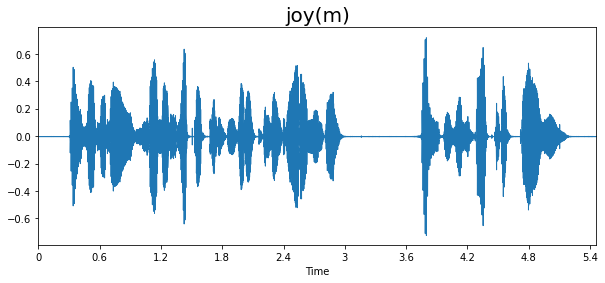

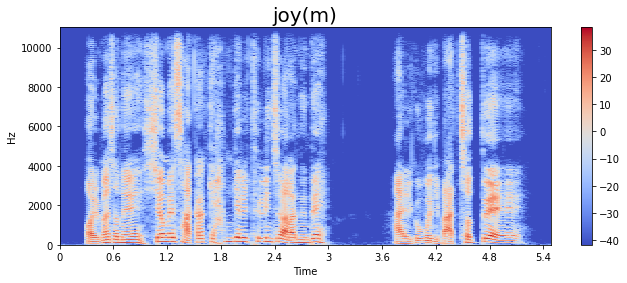

In [126]:
# 그래프(남성, 기쁨)

emotion = 'joy(m)'
path = np.array(df['location'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

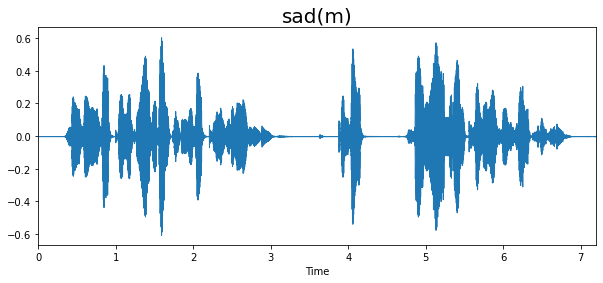

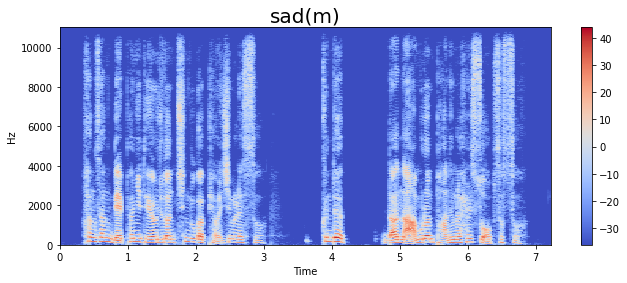

In [127]:
# 그래프(남성, 슬픔)

emotion = 'sad(m)'
path = np.array(df['location'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [163]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [203]:
# 남성

X_mfcc = dfm['location'].apply(lambda x: extract_mfcc(x))
X_mfcc

1000    [-289.7205, 98.15341, 2.1179376, 35.993126, 11...
1001    [-270.4289, 106.22055, 7.893259, 34.007202, -2...
1002    [-299.81635, 93.09561, 10.6319475, 37.479572, ...
1003    [-288.78174, 93.5694, 19.723726, 30.84854, -1....
1004    [-267.89072, 111.83588, 12.938153, 32.453873, ...
                              ...                        
8995    [-272.89465, 85.29213, 5.891779, 6.51013, -2.4...
8996    [-317.84283, 84.15983, 5.279484, 7.754674, 0.6...
8997    [-344.81665, 79.29709, -1.6904616, 5.4345613, ...
8998    [-333.4178, 92.18269, 2.4475515, 14.239323, 4....
8999    [-314.02933, 95.99886, 2.1438832, 8.3604145, -...
Name: location, Length: 3163, dtype: object

In [202]:
# 여성

X_mfcc_a = dff['location'].apply(lambda xa: extract_mfcc(xa))
X_mfcc_a

153     [-258.3903, 71.01722, 18.675983, 12.018395, -1...
154     [-312.4318, 64.963234, 12.299529, 19.648655, 1...
155     [-332.77493, 68.22045, 24.662354, 12.321093, -...
156     [-328.62878, 44.381676, 20.997301, 18.341166, ...
157     [-292.9722, 80.569756, 13.274215, 8.791714, -6...
                              ...                        
5995    [-267.31348, 85.537056, 4.242634, 20.833015, 2...
5996    [-278.60605, 79.67383, 4.9673476, 19.118715, -...
5997    [-262.41086, 98.240036, 2.472784, 17.381668, 4...
5998    [-313.8975, 91.51603, 9.714173, 12.292151, -5....
5999    [-278.47726, 78.19391, 2.2522104, 17.430758, 0...
Name: location, Length: 2714, dtype: object

In [204]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(3163, 40)

In [206]:
Xa = [xa for xa in X_mfcc_a]
Xa = np.array(Xa)
Xa.shape

(2714, 40)

In [166]:

# X = np.expand_dims(X, -1)
# X.shape

(3163, 40, 1)

In [179]:
# 남성

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(dfm[['label']])


# 여성

enc = OneHotEncoder()
z = enc.fit_transform(dff[['label']])

In [180]:
y = y.toarray()
z = z.toarray()

In [181]:
print(y.shape)
print(z.shape)

(3163, 4)
(2714, 4)


# 4. LSTM 모델

In [207]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 256)               264192    
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 7)               

In [208]:
# 모델 훈련(남성)

train_mode_m = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50


ValueError: ignored

# 0. 저장소(실수 처리)

In [131]:
# # (M) 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("(M)","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [132]:
# # (F) 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("(F)","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [133]:
# # _sad 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_sad","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [134]:
# # _ang 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_ang","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [135]:
# # _aiety 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_aiety","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [136]:
# # _joy 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_joy","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [137]:
# # _panic 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_panic","")
#     print("new:",new_title)
#     os.rename(src, new_title)

In [138]:
# # _hurt 일괄 삭제

# a = '/content/drive/MyDrive/음성인식/'
# file_list = os.listdir(a)
# file_lists = [file for file in file_list if file.endswith(".wav")] 

# for name in file_lists:
#     src = os.path.join(a, name)
#     print("src:", src)
#     new_title = src.replace("_hurt","")
#     print("new:",new_title)
#     os.rename(src, new_title)